In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 512

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
# Load training data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)
# Load and preprocess test images
test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test',  # Path to the test dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5846 images belonging to 7 classes.
Found 647 images belonging to 7 classes.
Found 717 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Create Precision and Recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)  # Use pre-created metric
    recall = recall_metric(y_true, y_pred)      # Use pre-created metric
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Apply mixed precision for faster training and less GPU load
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained EfficientNetB3 model without the top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Apply the output layer to the previous layer's output
output = Dense(7, activation='softmax')(x)  # 7 classes: anger, disgust, fear, happiness, neutral, sadness and surprise

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 11,574,070 (44.15 MB)

 Trainable params: 790,535 (3.02 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5130s 230s/step - accuracy: 0.3189 - f1_score: 0.0769 - loss: 1.7400 - precision: 0.5485 - recall: 0.0877 - val_accuracy: 0.4199 - val_f1_score: 0.2615 - val_loss: 1.5324 - val_precision: 0.6094 - val_recall: 0.2285
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4844 - f1_score: 0.2696 - loss: 1.3615 - precision: 0.7234 - recall: 0.2656

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4844 - f1_score: 0.2696 - loss: 1.3615 - precision: 0.7234 - recall: 0.2656 - val_accuracy: 0.4746 - val_f1_score: 0.2743 - val_loss: 1.4621 - val_precision: 0.6703 - val_recall: 0.2383
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5228 - f1_score: 0.3055 - loss: 1.2987 - precision: 0.7145 - recall: 0.3103 - val_accuracy: 0.4785 - val_f1_score: 0.3608 - val_loss: 1.4327 - val_precision: 0.6017 - val_recall: 0.2715
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.5508 - f1_score: 0.3627 - loss: 1.3094 - precision: 0.7083 - recall: 0.3320 - val_accuracy: 0.4961 - val_f1_score: 0.3647 - val_loss: 1.3594 - val_precision: 0.6598 - val_recall: 0.3145
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5657 - f1_score: 0.3811 - loss: 1.1875 - precision: 0.7381 - recall: 0.3880 - val_accuracy: 0.5176 - val_f1_score: 0.4139 - val_loss: 1.3282 - val_precision: 0.6693 - val_recall: 0.3320
Epoch 6/3

In [ ]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 24s/step - accuracy: 0.6284 - f1_score: 0.5916 - loss: 1.0537 - precision: 0.7360 - recall: 0.5203
Test Accuracy: 61.51%


In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Add more epochs for fine-tuning
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 503s 12s/step - accuracy: 0.3794 - f1_score: 0.5879 - loss: 1.7928 - precision: 0.4565 - recall: 0.2641 - val_accuracy: 0.5605 - val_f1_score: 0.5836 - val_loss: 1.3074 - val_precision: 0.6074 - val_recall: 0.5137
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.5781 - f1_score: 0.5835 - loss: 1.1046 - precision: 0.6595 - recall: 0.4766

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.5781 - f1_score: 0.5835 - loss: 1.1046 - precision: 0.6595 - recall: 0.4766 - val_accuracy: 0.5566 - val_f1_score: 0.5833 - val_loss: 1.3839 - val_precision: 0.5919 - val_recall: 0.4844
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6416 - f1_score: 0.5839 - loss: 0.9725 - precision: 0.7247 - recall: 0.5494 - val_accuracy: 0.6816 - val_f1_score: 0.5866 - val_loss: 1.0341 - val_precision: 0.7121 - val_recall: 0.6230
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.6562 - f1_score: 0.5868 - loss: 0.8226 - precision: 0.7391 - recall: 0.5977 - val_accuracy: 0.6719 - val_f1_score: 0.5871 - val_loss: 1.0648 - val_precision: 0.7195 - val_recall: 0.6211
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7365 - f1_score: 0.5894 - loss: 0.7276 - precision: 0.7995 - recall: 0.6710 - val_accuracy: 0.6777 - val_f1_score: 0.5948 - val_loss: 0.8959 - val_precision: 0.7158 - val_recall: 0.6543
Epoch 6

In [ ]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8180 - f1_score: 0.7218 - loss: 0.6694 - precision: 0.8255 - recall: 0.8054
Test Accuracy: 81.76%


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.8231 - f1_score: 0.7359 - loss: 0.5882 - precision: 0.8297 - recall: 0.8158
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step


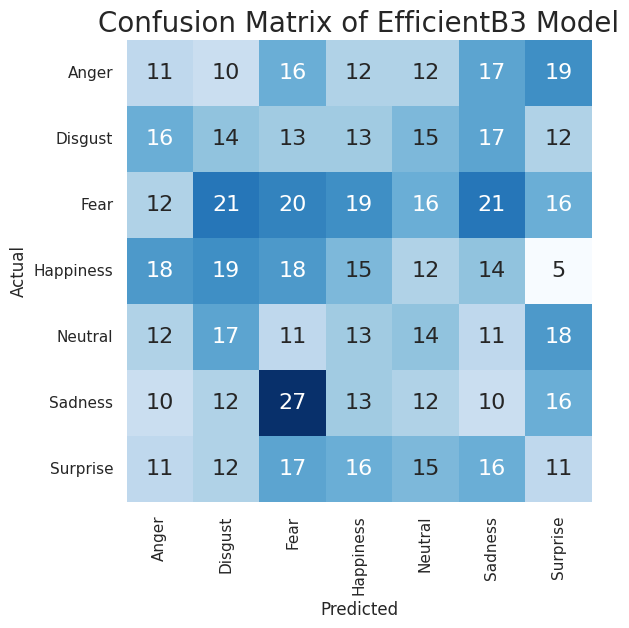

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (6,6))
plt.title('Confusion Matrix of EfficientB3 Model', fontsize = 20)
sns.set(font_scale=1.0)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(y_test, y_preds))

NameError: name 'LabelBinarizer' is not defined

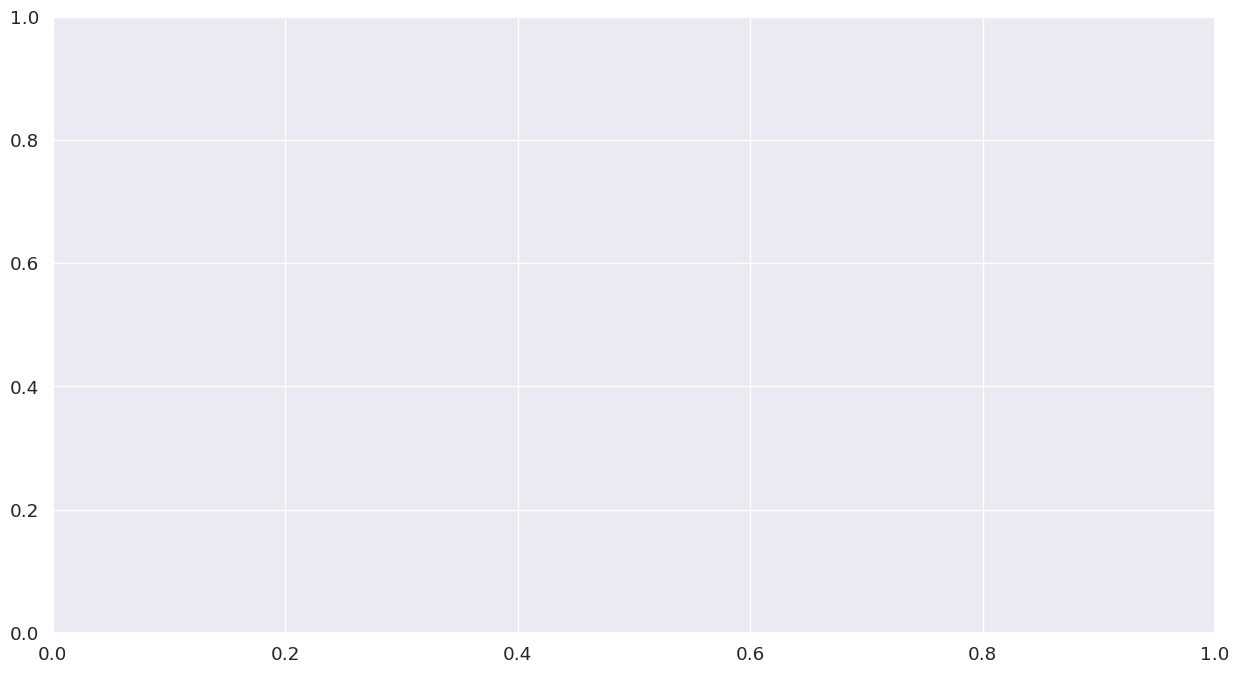

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (10,10))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

ROC AUC score: 0.5164713697433714


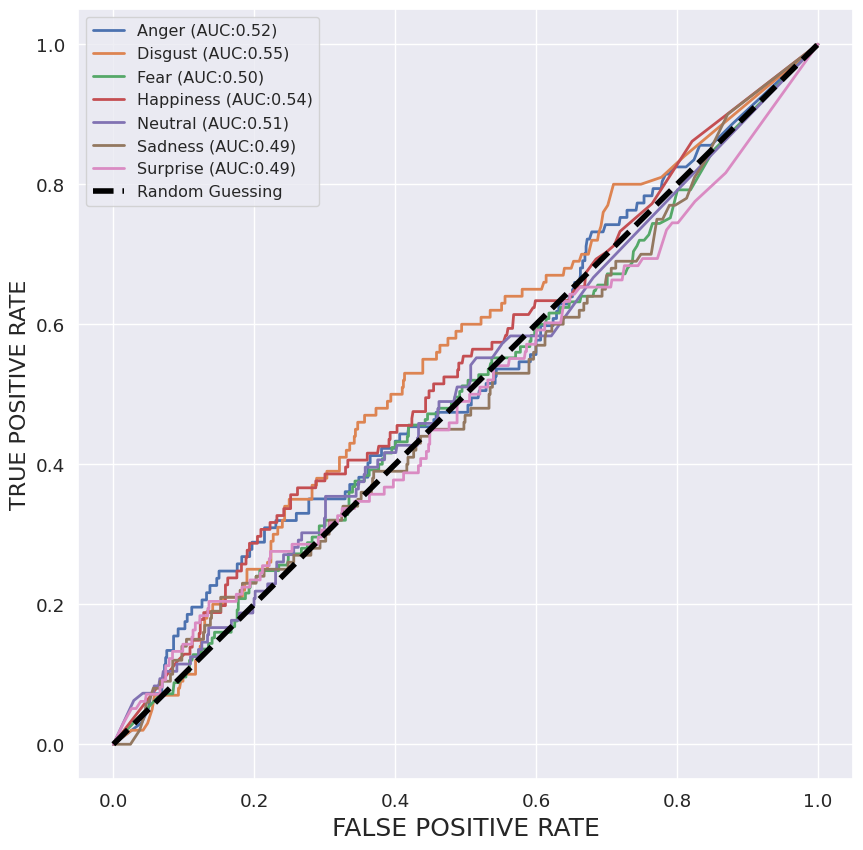

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc  # Import necessary metrics
from sklearn.preprocessing import LabelBinarizer # Import LabelBinarizer


CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# ... (rest of your code) ...

fig, c_ax = plt.subplots(1,1, figsize = (10,10))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer() # Now LabelBinarizer is defined
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

ROC AUC score for Happiness: 0.5164713697433714


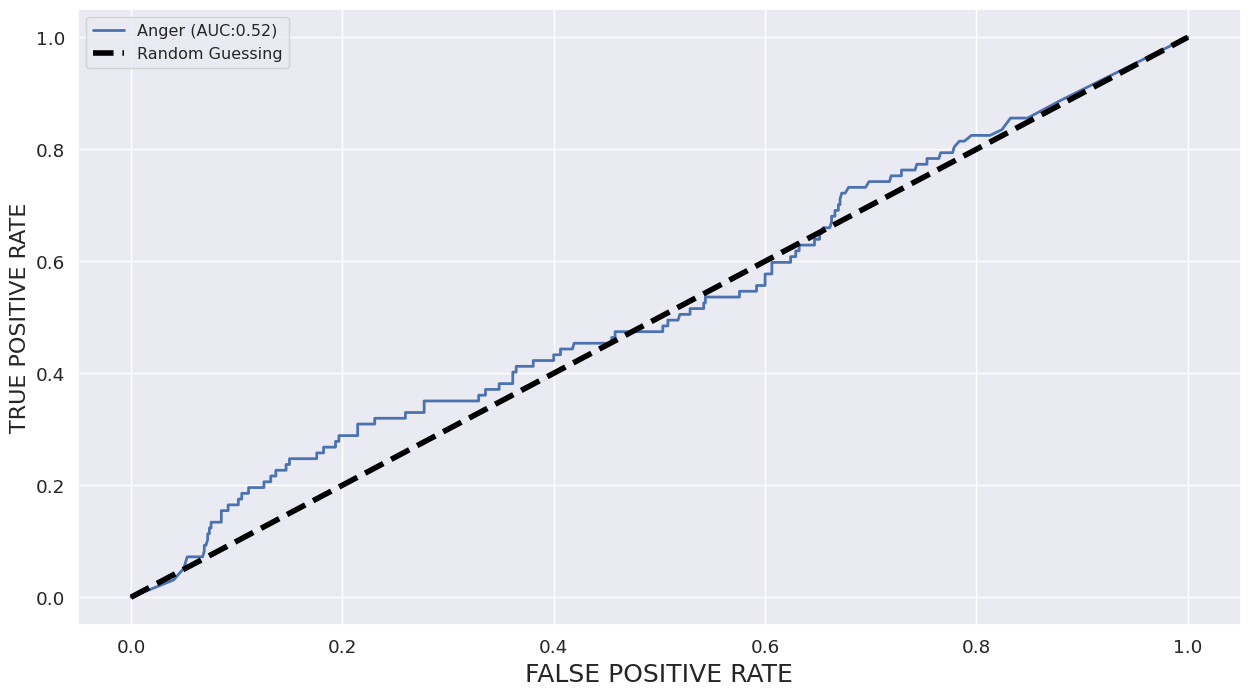

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc  # Import necessary metrics
from sklearn.preprocessing import LabelBinarizer # Import LabelBinarizer


CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# ... (rest of your code) ...

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, target_class="Anger", average="macro"):
    """
    Calculates and plots the ROC AUC curve for a specific class.

    Args:
        y_test: True labels.
        y_pred: Predicted probabilities.
        target_class: The class to plot the ROC AUC curve for.
        average: Averaging method for multiclass ROC AUC score.

    Returns:
        ROC AUC score for the target class.
    """
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)

    # Find the index of the target class
    target_class_index = CLASS_LABELS.index(target_class)

    # Calculate ROC curve and AUC for the target class
    fpr, tpr, thresholds = roc_curve(y_test[:, target_class_index].astype(int), y_pred[:, target_class_index])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (target_class, roc_auc))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average)  # Return overall ROC AUC score

print('ROC AUC score for Happiness:', multiclass_roc_auc_score(y_test, preds, target_class="Anger", average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))


NameError: name 'to_categorical' is not defined

In [ ]:
!pip install tensorflow
import tensorflow as tf

print("ROC-AUC Score  = " ,tf.keras.utils.to_categorical(y_test) , preds)

ROC-AUC Score  =  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]] [[1.0967e-05 2.3842e-07 2.1636e-05 ... 3.5763e-07 1.0000e+00 5.3644e-07]
 [5.9605e-07 0.0000e+00 0.0000e+00 ... 9.9902e-01 9.1076e-04 0.0000e+00]
 [9.9805e-01 2.0087e-05 1.2732e-03 ... 0.0000e+00 2.6822e-06 3.0947e-04]
 ...
 [1.0639e-04 2.7537e-05 3.5763e-07 ... 6.5565e-07 1.0000e+00 1.1921e-07]
 [2.2840e-04 1.0294e-04 1.2836e-03 ... 7.4730e-03 9.7510e-01 5.8794e-04]
 [8.9407e-06 5.9605e-08 4.4751e-01 ... 1.0729e-06 2.8014e-06 5.5225e-01]]


In [ ]:
from sklearn.metrics import classification_report # Import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.21      0.20      0.20        97
           1       0.18      0.19      0.19       100
           2       0.17      0.17      0.17       125
           3       0.19      0.19      0.19       101
           4       0.15      0.15      0.15        96
           5       0.18      0.19      0.18       100
           6       0.20      0.19      0.19        98

    accuracy                           0.18       717
   macro avg       0.18      0.18      0.18       717
weighted avg       0.18      0.18      0.18       717

